# Nonlinear Poisson equation 

$$-div(q(u)*\Delta(u)) = 0,$$
$$u = 0\text{ at }x=0, u=1\text{ at }x=1$$
$$q(u) = (1+u)^m$$

Solution method: Newton method

Newton iteration is a more sophisticated method for solving nonlinear equations and systems. It is based on linearizing the original problem around an initial guess and then iteratively improving the solution by solving linear approximations of the problem.

The Newton method is known for its quadratic convergence, which means that the number of correct digits in the solution roughly doubles with each iteration, making it faster than Picard iteration for problems where it converges.

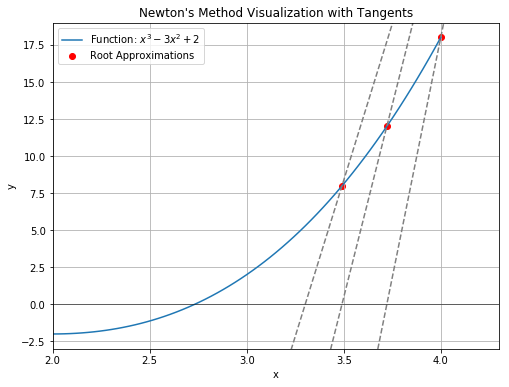

In [279]:
import matplotlib.pyplot as plt
import numpy as np

def newton_method(func, derivative, x0, tolerance=1e-6, max_iterations=2):
    x_vals = [x0]
    iteration = 0

    while iteration < max_iterations:
        x_next = x_vals[-1] - func(x_vals[-1]) / derivative(x_vals[-1])
        x_vals.append(x_next)

        if abs(x_vals[-1] - x_vals[-2]) < tolerance:
            break

        iteration += 1

    return x_vals

# Define the function and its derivative
def func(x):
    return x**3 - 3*x**2 + 2

def derivative(x):
    tangent_modifier = 2.7
    return tangent_modifier*(3*x**2 - 6*x)

# Initial guess for the root and perform Newton's method
initial_guess = 4
root_approximations = newton_method(func, derivative, initial_guess)

# Visualization
x_vals = np.linspace(1, 4, 100)
y_vals = func(x_vals)

plt.figure(figsize=(8, 6))
plt.plot(x_vals, y_vals, label='Function: $x^3 - 3x^2 + 2$')
plt.scatter(root_approximations, [func(root) for root in root_approximations], c='red', label='Root Approximations')

for i, root in enumerate(root_approximations):
    # plt.annotate(f'Root {i+1}', xy=(root, func(root)), xytext=(root+0.4, func(root) + 4), arrowprops=dict(arrowstyle='->', lw=1.5))

    # Plotting tangent lines
    tangent_x = np.linspace(root - 2, root + 2, 100)
    tangent_y = func(root) + derivative(root) * (tangent_x - root)
    plt.plot(tangent_x, tangent_y, linestyle='dashed', color='gray')

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Set xlim and ylim based on the root approximations
plt.xlim(2, 4.3)
plt.ylim(min(y_vals) - 1, max(y_vals) + 1)


plt.title("Newton's Method Visualization with Tangents")
plt.grid(True)
plt.show()


---

In [207]:
from dolfin import *
import numpy
%matplotlib inline

mesh = IntervalMesh(40,0,1)
V = FunctionSpace(mesh, 'Lagrange', 1)

In [227]:
# Define boundary conditions

tol = 1E-14


left_boundary = CompiledSubDomain("on_boundary && near(x[0],0)")
right_boundary = CompiledSubDomain("on_boundary && near(x[0],1)")


bc_0 = DirichletBC(V, Constant(0.0), left_boundary)
bc_1 = DirichletBC(V, Constant(1.0), right_boundary)
bcs = [bc_0, bc_1]

In [228]:
m = 5


def q(u):
    return (1+u)**m


def Dq(u):
    return m*(1+u)**(m-1)

Go to this link for derivation

https://home.simula.no/~hpl/homepage/fenics-tutorial/release-1.0/webm/nonlinear.html#a-newton-method-at-the-pde-level

In [229]:
# Define variational problem for initial guess (q(u)=1, i.e., m=0)
u = TrialFunction(V)
v = TestFunction(V)
a = inner(nabla_grad(u), nabla_grad(v))*dx
f = Constant(0.0)
L = f*v*dx
u_k = Function(V)
solve(a == L, u_k, bcs)

# Note that all Dirichlet conditions must be zero for
# the correction function in a Newton-type method
Gamma_0_du = DirichletBC(V, Constant(0.0), left_boundary)
Gamma_1_du = DirichletBC(V, Constant(0.0), right_boundary)
bcs_du = [Gamma_0_du, Gamma_1_du]

In [230]:

# Define variational problem for Newton iteration
du = TrialFunction(V)  # u = u_k + omega*du
a = inner(q(u_k)*nabla_grad(du), nabla_grad(v))*dx + \
    inner(Dq(u_k)*du*nabla_grad(u_k), nabla_grad(v))*dx
L = -inner(q(u_k)*nabla_grad(u_k), nabla_grad(v))*dx

# Newton iteration at the PDE level
du = Function(V)
u  = Function(V)  # u = u_k + omega*du
omega = 1.0       # relaxation parameter
absolute_error = 1.0
relative_error = 1.0
absolute_tolerance = 1.0E-5        # tolerance
relative_tolerance = 1.0E-5
iter = 0
maxiter = 25
# u_k must have right boundary conditions here
while (absolute_error > absolute_tolerance or relative_error > relative_tolerance) and iter < maxiter:
    iter += 1
    A, b = assemble_system(a, L, bcs_du)
    solve(A, du.vector(), b)
    diff = du.vector()[:]
    absolute_error = numpy.linalg.norm(diff)
    relative_error = absolute_error/numpy.linalg.norm(u_k.vector()[:])
    u.vector()[:] = u_k.vector() + omega*du.vector()
    print('iter ={0:3d}, absolute_error = {1:5.2e}, relative_error = {2:5.2e}'.format(
        iter, absolute_error, relative_error))
    u_k.assign(u)

iter =  1, absolute_error = 2.87e+00, relative_error = 7.71e-01
iter =  2, absolute_error = 9.00e-01, relative_error = 1.55e-01
iter =  3, absolute_error = 3.63e-01, relative_error = 7.10e-02
iter =  4, absolute_error = 6.46e-02, relative_error = 1.32e-02
iter =  5, absolute_error = 2.21e-03, relative_error = 4.53e-04
iter =  6, absolute_error = 2.98e-06, relative_error = 6.12e-07


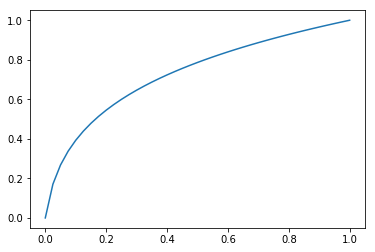

In [231]:
plot(u)

In [232]:
# Find max error
u_exact = Expression(
    'pow((pow(2, m+1)-1)*x[0] + 1, 1.0/(m+1)) - 1', m=m, degree=1)
u_e = interpolate(u_exact, V)
diff = numpy.abs(u_e.vector()[:] - u.vector()[:]).max()
print('Max error:{0:5.3e}'.format(diff))

Max error:4.014e-12
